# DRL_PFOpt_XP - TD3 Training Tests
#### 2022/11/13, AJ Zerouali

Goals:

* Implement and test new features for the environment and agent classes of *DRL_PFOpt*.
* Find adequate parameters for the training of a TD3 agent for portfolio optimization

## Imports and Dow Jones Data

In [4]:
# Kill warnings
from warnings import filterwarnings
filterwarnings("ignore")

### Basics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
%matplotlib inline
import datetime
import itertools

### OpenAI Gym and StableBaselines3
from gym.utils import seeding
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

### What is this?
import sys

### My imports (22/11/04, AJ Zerouali)
import DRL_PFOpt_Utils
import DRL_PFOpt_Data
import DRL_PFOpt_gymEnv
import DRL_PFOpt_Agent

# Experimental implementations
from DRL_PFOpt_XP import PFOptAgent_XP, PFOptEnv_XP

# Load Dow Jones data
df_file = pd.read_csv(filepath_or_buffer="datasets/DJIA30_data_0801-0908.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

# Instantiate feature engineering object
FeatureEng = DRL_PFOpt_Data.FeatureEngineer(tech_indicator_list = ["turbulence"],
                                                 use_return_covs = True,
                                                 n_lookback_prds = 90)

# Preprocess df_file
df_X, np_close_returns, np_returns_cov = FeatureEng.preprocess_data(df_X = df_file)

Successfully computed asset returns and their covariances
Successfully added technical indicators
Successfully added turbulence index


In [5]:
# Train and test dates
start_train_date = '2008-12-31'
end_train_date = '2020-07-01'
start_test_date = end_train_date
end_test_date = '2021-09-02'

In [6]:
df_train, ret_X_train, cov_X_train = DRL_PFOpt_Data.data_split(df_X = df_X, 
                                                                    start=start_train_date, 
                                                                    end = end_train_date,
                                                                    use_returns_cov = True,
                                                                    ret_X= np_close_returns,
                                                                    cov_X=np_returns_cov)

Dataframe, returns and cov have same number of dates


In [7]:
df_test, ret_X_test, cov_X_test = DRL_PFOpt_Data.data_split(df_X = df_X, 
                                                                    start=start_test_date, 
                                                                    end = end_test_date,
                                                                    use_returns_cov = True,
                                                                    ret_X= np_close_returns,
                                                                    cov_X=np_returns_cov)

Dataframe, returns and cov have same number of dates


**Get benchmark data**

Benchmark data (DJIA) over testing dates.

In [25]:
df_DJI_benchmark, df_DJI_returns = DRL_PFOpt_Utils.get_benchmark_prices_and_returns(
                    ticker = "^DJI", start_date = '2020-07-01', end_date = '2021-09-02')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (296, 8)


## TD3 Baseline training - SftMx Weights

Start simple here. Results are bad.

**1) My baseline trial:**

Env. params:

            n_lookback_prds = 90
            pf_value_ini = 1000000
            reward_type= 'portfolio_return'
            state_struct_list = ['open','high','low','close', 'volume', 'weights']
            tech_ind_list = []
            transaction_cost_pct = 0
            weight_normalization = "softmax"

Agent params:

            TD3_PARAMS = {"batch_size": 512, 
              "buffer_size": 10000, 
              "learning_rate": 0.01,
              "gamma":0}

First 2 training rounds:

            =================================
            Initial portfolio value: 1000000
            End portfolio value: 6048183.543016752
            Yearly Sharpe ratio at last period: 0.9603847599155504
            =================================
            =================================
            Initial portfolio value: 1000000
            End portfolio value: 6014091.28494405
            Yearly Sharpe ratio at last period: 0.9631827578485916
            =================================

Good losses at round 12.

Results:

            Annual return	30.5%
            Cumulative returns	36.7%
            Annual volatility	14.1%
            Sharpe ratio	1.96
            
**Comment:** Using *deterministic* True or False in backtest gives the exact same result.

In [6]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "softmax"

In [7]:
train_env_sftmx = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [8]:
test_env_sftmx = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [10]:
train_env_sftmx.N_periods

2894

In [12]:
# Instantiate agent
TD3_Agent_OHCLVW_SftMx = PFOptAgent_XP(train_env = train_env_sftmx)

In [13]:
TD3_PARAMS = {"batch_size": 512, 
              "buffer_size": 10000, 
              "learning_rate": 0.01,
              "gamma":0}

TD3_Agent_OHCLVW_SftMx.set_model(model_name = "td3",
                                seed = 0,
                                model_kwargs=TD3_PARAMS)

TD3_Agent_OHCLVW_SftMx.train_model(tb_log_name='td3',
                                  n_train_rounds=12)

{'batch_size': 512, 'buffer_size': 10000, 'learning_rate': 0.01, 'gamma': 0}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3 with given parameters has been successfully created.
Initial portfolio value: 1000000
End portfolio value: 6048183.543016752
Yearly Sharpe ratio at last period: 0.9603847599155504
Initial portfolio value: 1000000
End portfolio value: 6014091.28494405
Yearly Sharpe ratio at last period: 0.9631827578485916
Initial portfolio value: 1000000
End portfolio value: 6014091.28494405
Yearly Sharpe ratio at last period: 0.9631827578485916
Initial portfolio value: 1000000
End portfolio value: 6014091.28494405
Yearly Sharpe ratio at last period: 0.9631827578485916
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 2.89e+03    |
|    ep_rew_mean     | 1.99        |
| time/              |             |
|    episodes        | 4           |
|    fps             | 87          |
|    ti

In [16]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = TD3_Agent_OHCLVW_SftMx.run_backtest(test_env = test_env_sftmx,)

Initial portfolio value: 1000000
End portfolio value: 1367341.0867413254
Yearly Sharpe ratio at last period: 1.9647111466008431
Finished running backtest. Storing results...


In [17]:
df_pf_value_hist_sto, df_pf_return_hist_sto, \
df_pf_weights_hist_sto, df_agt_action_hist_sto\
 = TD3_Agent_OHCLVW_SftMx.run_backtest(test_env = test_env_sftmx, deterministic = False)

Initial portfolio value: 1000000
End portfolio value: 1367341.0867413254
Yearly Sharpe ratio at last period: 1.9647111466008431
Finished running backtest. Storing results...


True

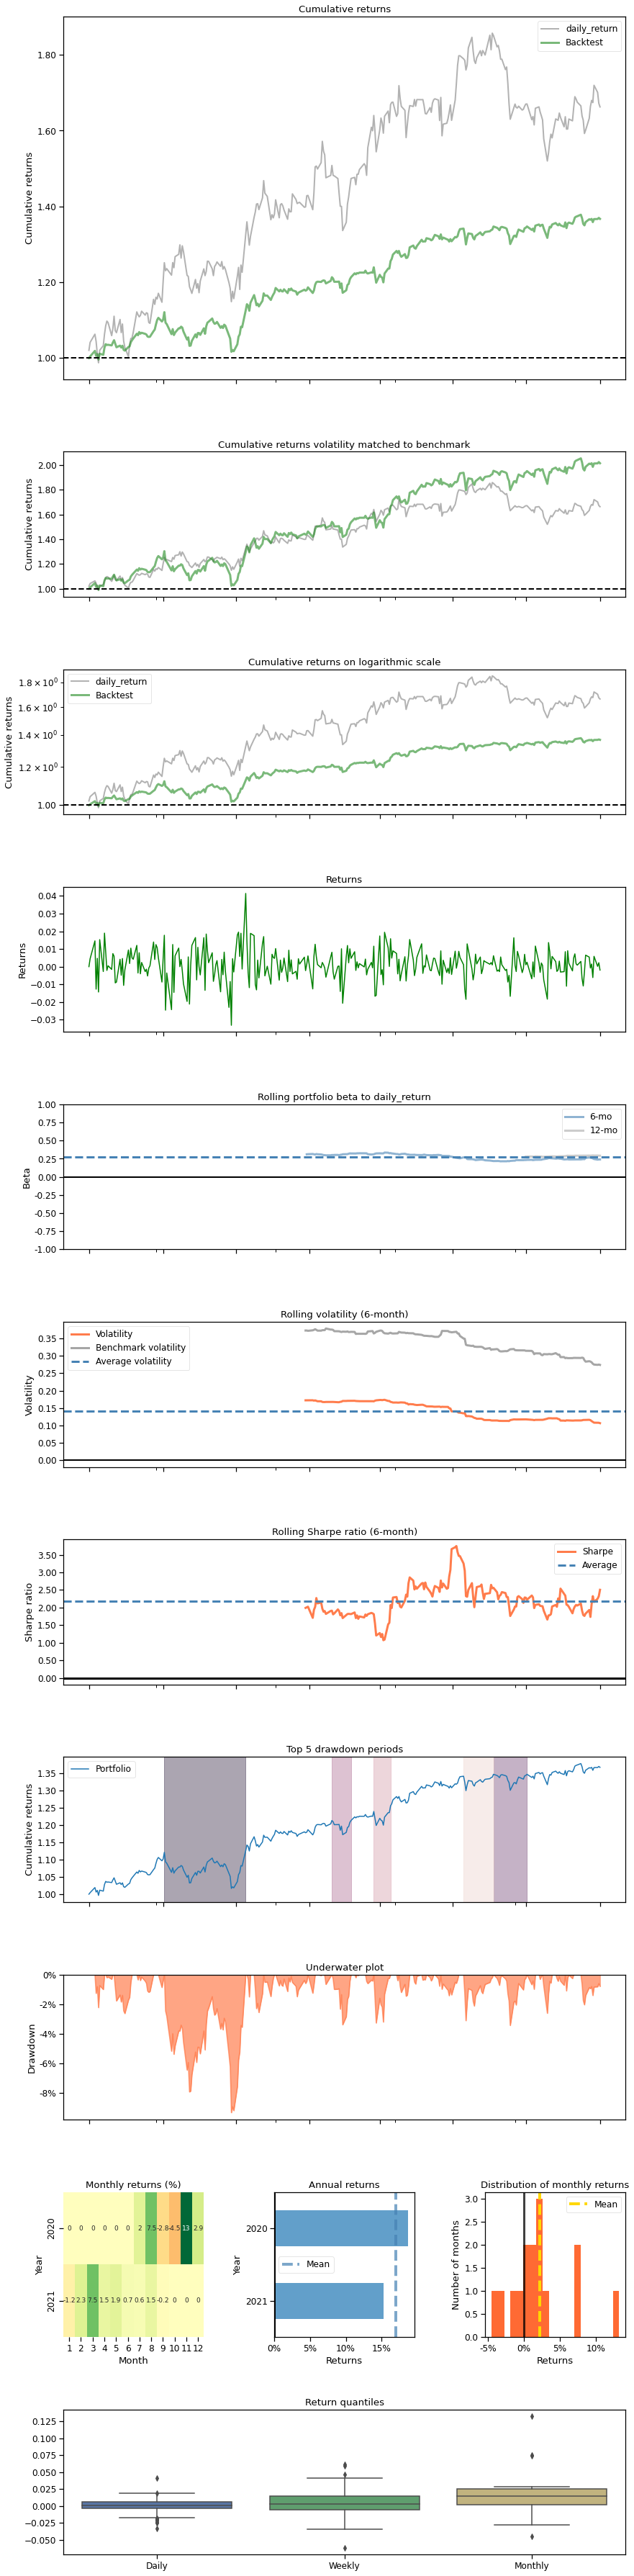

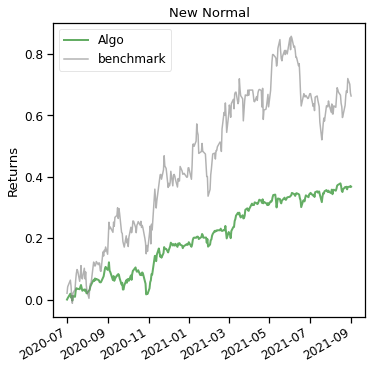

In [31]:
%matplotlib inline
TD3_Agent_OHCLVW_SftMx.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

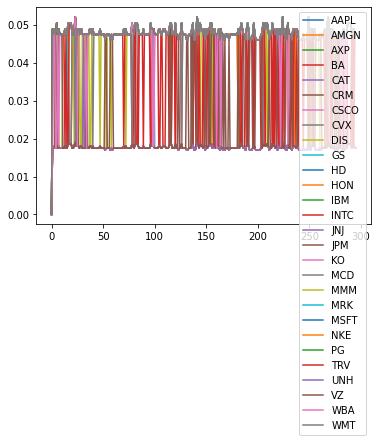

In [32]:
TD3_Agent_OHCLVW_SftMx.pf_weights_hist.plot()

<AxesSubplot:>

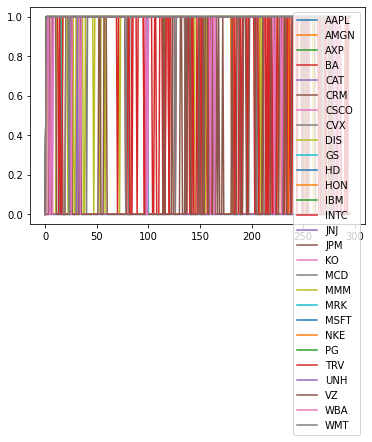

In [33]:
TD3_Agent_OHCLVW_SftMx.agt_action_hist.plot()

Yup...

## TD3 Baseline training - ReLU Weights

Start simple here. Results are bad.

**1) My baseline parameters:**

Env. params:

        n_lookback_prds = 90
        pf_value_ini = 1000000
        reward_type= 'portfolio_return'
        state_struct_list = ['open','high','low','close', 'volume', 'weights']
        tech_ind_list = []
        transaction_cost_pct = 0
        weight_normalization = "relu"
        
Agent params:

        TD3_PARAMS = {"batch_size": 512, 
              "buffer_size": 10000, 
              "learning_rate": 0.01,
              "gamma":0}
        
First 2 rounds of training: 

        =================================
        Initial portfolio value: 1000000
        End portfolio value: 5823981.288981951
        Yearly Sharpe ratio at last period: 0.9465779639552603
        =================================
        =================================
        Initial portfolio value: 1000000
        End portfolio value: 5785431.243653284
        Yearly Sharpe ratio at last period: 0.9533282970013408
        =================================
        
Good losses at round 12.

Results:

        Annual return	27.2%
        Cumulative returns	32.7%
        Annual volatility	14.5%
        Sharpe ratio	1.73
        
**Comment:** Using *deterministic* True or False in backtest gives the exact same result.

In [18]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "relu"

In [19]:
train_env_relu = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [20]:
test_env_relu = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [21]:
train_env_relu.N_periods

2894

In [22]:
# Instantiate agent
TD3_Agent_OHCLVW_ReLU = PFOptAgent_XP(train_env = train_env_relu)

In [23]:
TD3_PARAMS = {"batch_size": 512, 
              "buffer_size": 10000, 
              "learning_rate": 0.01,
              "gamma":0}

TD3_Agent_OHCLVW_ReLU.set_model(model_name = "td3",
                                seed = 0,
                                model_kwargs=TD3_PARAMS)

TD3_Agent_OHCLVW_ReLU.train_model(tb_log_name='td3',
                                  n_train_rounds=12)

{'batch_size': 512, 'buffer_size': 10000, 'learning_rate': 0.01, 'gamma': 0}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3 with given parameters has been successfully created.
Initial portfolio value: 1000000
End portfolio value: 5823981.288981951
Yearly Sharpe ratio at last period: 0.9465779639552603
Initial portfolio value: 1000000
End portfolio value: 5785431.243653284
Yearly Sharpe ratio at last period: 0.9533282970013408
Initial portfolio value: 1000000
End portfolio value: 5785431.243653284
Yearly Sharpe ratio at last period: 0.9533282970013408
Initial portfolio value: 1000000
End portfolio value: 5785431.243653284
Yearly Sharpe ratio at last period: 0.9533282970013408
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 2.89e+03   |
|    ep_rew_mean     | 1.95       |
| time/              |            |
|    episodes        | 4          |
|    fps             | 89         |
|    time_e

In [26]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = TD3_Agent_OHCLVW_ReLU.run_backtest(test_env = test_env_relu,)

Initial portfolio value: 1000000
End portfolio value: 1327122.9853601516
Yearly Sharpe ratio at last period: 1.737465968850435
Finished running backtest. Storing results...


In [27]:
df_pf_value_hist_sto, df_pf_return_hist_sto, \
df_pf_weights_hist_sto, df_agt_action_hist_sto\
 = TD3_Agent_OHCLVW_ReLU.run_backtest(test_env = test_env_relu, deterministic = False)

Initial portfolio value: 1000000
End portfolio value: 1327122.9853601516
Yearly Sharpe ratio at last period: 1.737465968850435
Finished running backtest. Storing results...


True

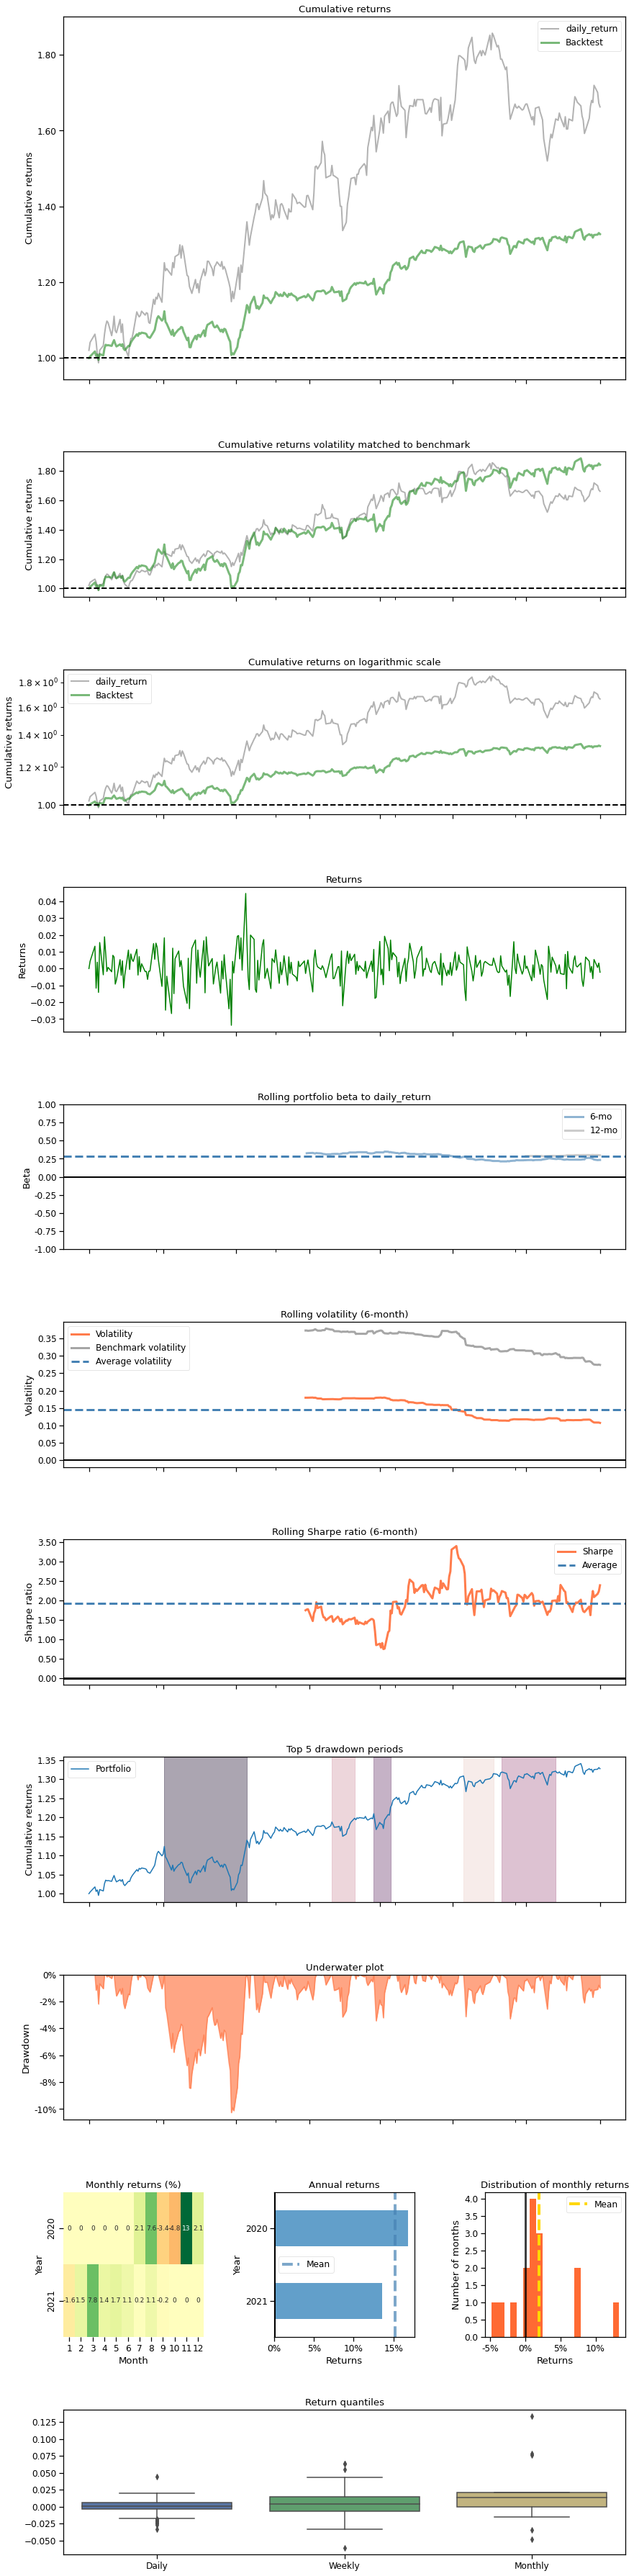

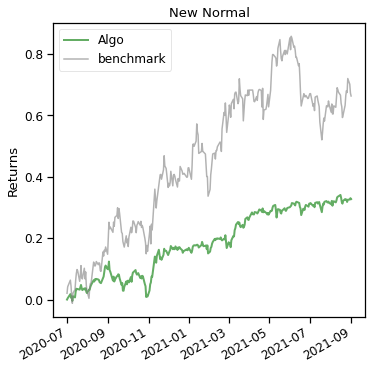

In [28]:
%matplotlib inline
TD3_Agent_OHCLVW_ReLU.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

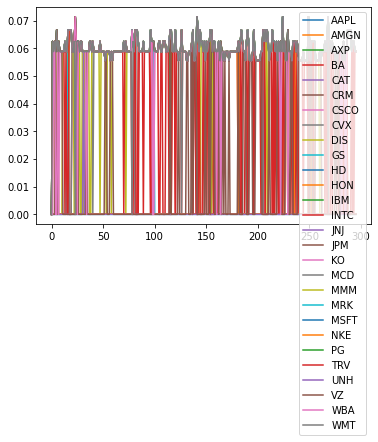

In [29]:
TD3_Agent_OHCLVW_ReLU.pf_weights_hist.plot()

<AxesSubplot:>

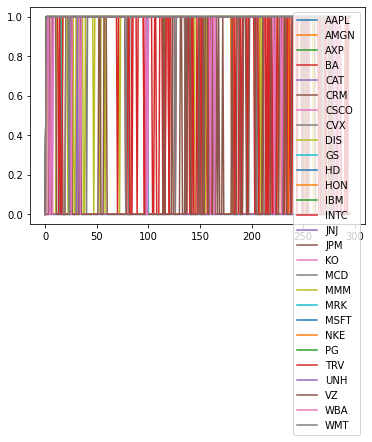

In [30]:
TD3_Agent_OHCLVW_ReLU.agt_action_hist.plot()

## TD3 SftMx Weights - Normal noise

Adding exploration noise this time.

**1) First trial:**

Env. Params:

        n_lookback_prds = 90
        pf_value_ini = 1000000
        reward_type= 'portfolio_return'
        state_struct_list = ['open','high','low','close', 'volume', 'weights']
        tech_ind_list = []
        transaction_cost_pct = 0
        weight_normalization = "softmax"
        
Agent params:

        TD3_PARAMS = {"batch_size": 512, 
                      "buffer_size": 10000, 
                      "learning_rate": 0.01,
                      "gamma":0,
                      "action_noise":"normal",}

Results: Just as bad as above. This time the Sharpe ratio and the accumulated wealth change at the end of each training round.

        Annual return	30.5%
        Cumulative returns	36.7%
        Annual volatility	14.1%
        Sharpe ratio	1.96
        
**2) Removing the seed**

No substantial improvement, even after 36 training rounds:

        Annual return	30.9%
        Cumulative returns	37.2%
        Annual volatility	13.8%
        Sharpe ratio	2.02

In [6]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "softmax"

In [7]:
train_env_sftmx = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [8]:
test_env_sftmx = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [9]:
train_env_sftmx.N_periods

2894

In [38]:
del TD3_Agent_OHCLVW_SftMx

In [39]:
# Instantiate agent
TD3_Agent_OHCLVW_SftMx = PFOptAgent_XP(train_env = train_env_sftmx)

In [40]:
TD3_PARAMS = {"batch_size": 500, 
              "buffer_size": 10000, 
              "learning_rate": 0.01,
              "gamma":0,
              "action_noise":"normal",}

TD3_Agent_OHCLVW_SftMx.set_model(model_name = "td3",
                                #seed = 0,
                                model_kwargs=TD3_PARAMS)

{'batch_size': 500, 'buffer_size': 10000, 'learning_rate': 0.01, 'gamma': 0, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3 with given parameters has been successfully created.


True

In [41]:
TD3_Agent_OHCLVW_SftMx.train_model(tb_log_name='td3',
                                  n_train_rounds=12)

Initial portfolio value: 1000000
End portfolio value: 5968176.13090993
Yearly Sharpe ratio at last period: 0.9775414149073988
Initial portfolio value: 1000000
End portfolio value: 5628226.497975205
Yearly Sharpe ratio at last period: 0.9537309275586112
Initial portfolio value: 1000000
End portfolio value: 5658163.805170482
Yearly Sharpe ratio at last period: 0.9556724822737377


KeyboardInterrupt: 

In [42]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = TD3_Agent_OHCLVW_SftMx.run_backtest(test_env = test_env_sftmx,)

ERROR: Cannot run a backtest with an untrained agent


In [34]:
df_pf_value_hist_sto, df_pf_return_hist_sto, \
df_pf_weights_hist_sto, df_agt_action_hist_sto\
 = TD3_Agent_OHCLVW_SftMx.run_backtest(test_env = test_env_sftmx, deterministic = False)

Initial portfolio value: 1000000
End portfolio value: 1371668.7712863418
Yearly Sharpe ratio at last period: 2.0258154426387334
Finished running backtest. Storing results...


True

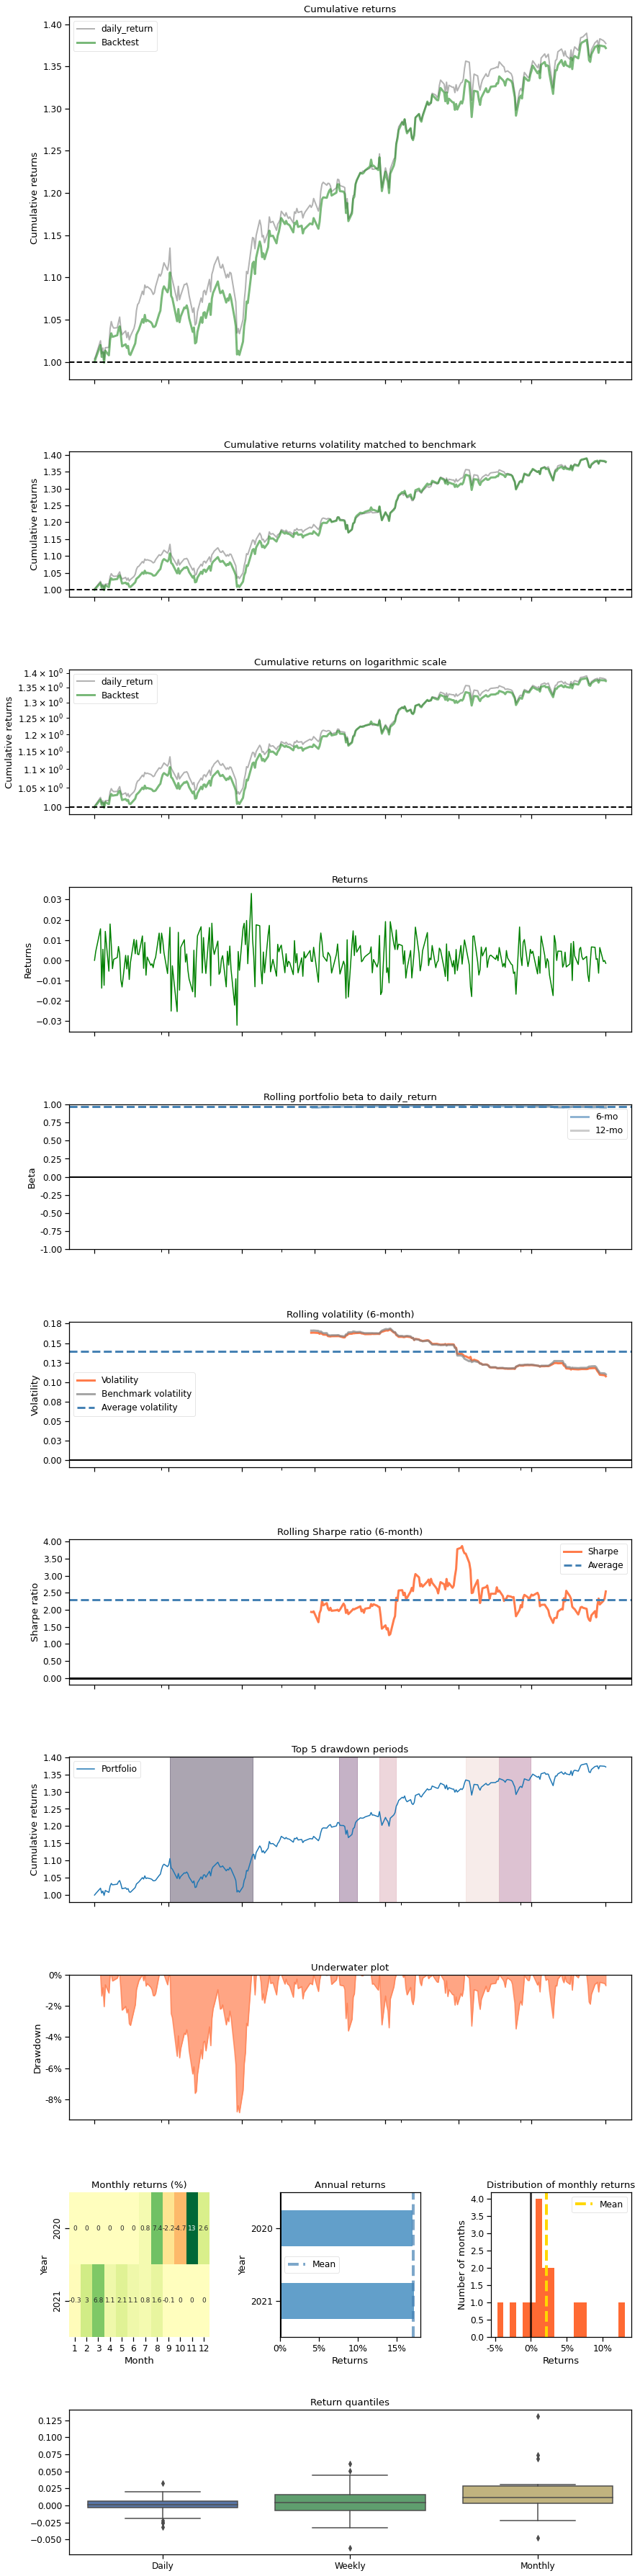

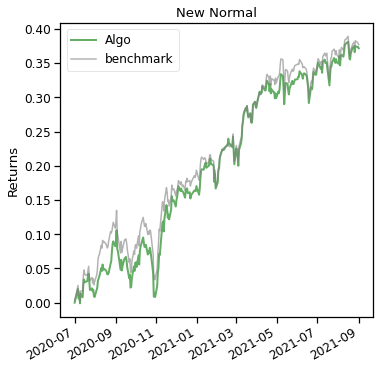

In [37]:
%matplotlib inline
TD3_Agent_OHCLVW_SftMx.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

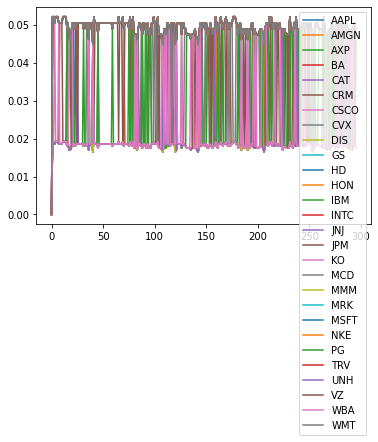

In [32]:
TD3_Agent_OHCLVW_SftMx.pf_weights_hist.plot()

<AxesSubplot:>

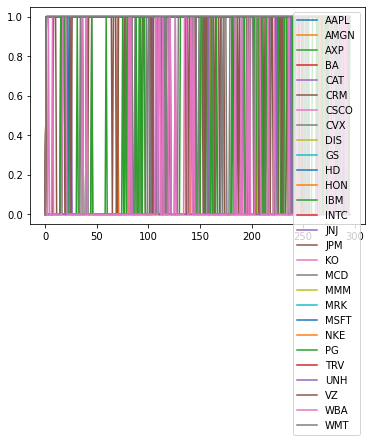

In [33]:
TD3_Agent_OHCLVW_SftMx.agt_action_hist.plot()

## TD3 SftMx Weights - Ornstein-Uhlenbeck noise

* Ornstein-Uhlenbeck process: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process

Adding exploration noise this time.

**1) First trial: No seed**

Env. Params:

        n_lookback_prds = 90
        pf_value_ini = 1000000
        reward_type= 'portfolio_return'
        state_struct_list = ['open','high','low','close', 'volume', 'weights']
        tech_ind_list = []
        transaction_cost_pct = 0
        weight_normalization = "softmax"
        
Agent params:

        TD3_PARAMS = {"batch_size": 500, 
                      "buffer_size": 10000, 
                      "learning_rate": 0.01,
                      "gamma":0,
                      "action_noise":"ornstein_uhlenbeck",}

Much better, but I restarted training each time the first round had a Sharpe ratio below 0.96.

        Annual return	37.1%
        Cumulative returns	44.9%
        Annual volatility	13.6%
        Sharpe ratio	2.39
        
**2) seed = 0**

Exact same params as above yield:

        Annual return	30.5%
        Cumulative returns	36.7%
        Annual volatility	14.1%
        Sharpe ratio	1.96
        
**3) seed = 169**

This one started the first round of training with a 1.0128 Sharpe. WTF?

Results:

        Annual return	36.8%
        Cumulative returns	44.5%
        Annual volatility	13.7%
        Sharpe ratio	2.35
        
I'm starting to see a pattern here. It's time to write a program to find a good seed.

First 2 training rounds:

        =================================
        Initial portfolio value: 1000000
        End portfolio value: 7051780.57104123
        Yearly Sharpe ratio at last period: 1.0128142356940004
        =================================
        =================================
        Initial portfolio value: 1000000
        End portfolio value: 6891166.491972162
        Yearly Sharpe ratio at last period: 0.9950554703851447
        =================================
        
As one would expect, restarting the training from scratch with the same seed gives the same results for the training rounds. Somehow, I also get the same results for the backtesting.

**3) seed = 1000**
Results weren't that good. 

**seed = 175**

Training:

    =================================
    Initial portfolio value: 1000000
    End portfolio value: 5965210.239536176
    Yearly Sharpe ratio at last period: 0.9531644050958975
    =================================

Test:

    =================================
    Initial portfolio value: 1000000
    End portfolio value: 1453491.8369343067
    Yearly Sharpe ratio at last period: 2.4090508184240127
    =================================
    Finished running backtest. Storing results...

**Best seed: 119**

In [6]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "softmax"

In [7]:
train_env_sftmx = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [8]:
test_env_sftmx = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [9]:
train_env_sftmx.N_periods

2894

In [20]:
del TD3_Agent_OHCLVW_SftMx

In [21]:
# Instantiate agent
TD3_Agent_OHCLVW_SftMx = PFOptAgent_XP(train_env = train_env_sftmx)

In [22]:
TD3_PARAMS = {"batch_size": 256, 
              "buffer_size": 10000, 
              "learning_rate": 0.01,
              "gamma":0,
              "action_noise":"ornstein_uhlenbeck",}

TD3_Agent_OHCLVW_SftMx.set_model(model_name = "td3",
                                seed = 119,
                                model_kwargs=TD3_PARAMS)

{'batch_size': 256, 'buffer_size': 10000, 'learning_rate': 0.01, 'gamma': 0, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3 with given parameters has been successfully created.


True

In [23]:
TD3_Agent_OHCLVW_SftMx.train_model(tb_log_name='td3',
                                  n_train_rounds=1)

Initial portfolio value: 1000000
End portfolio value: 6601671.517020924
Yearly Sharpe ratio at last period: 0.9688385384269784


In [24]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = TD3_Agent_OHCLVW_SftMx.run_backtest(test_env = test_env_sftmx,)

Initial portfolio value: 1000000
End portfolio value: 1492377.2375533646
Yearly Sharpe ratio at last period: 2.4698110147193413
Finished running backtest. Storing results...


In [ ]:
df_pf_value_hist_sto, df_pf_return_hist_sto, \
df_pf_weights_hist_sto, df_agt_action_hist_sto\
 = TD3_Agent_OHCLVW_SftMx.run_backtest(test_env = test_env_sftmx, deterministic = False)

True

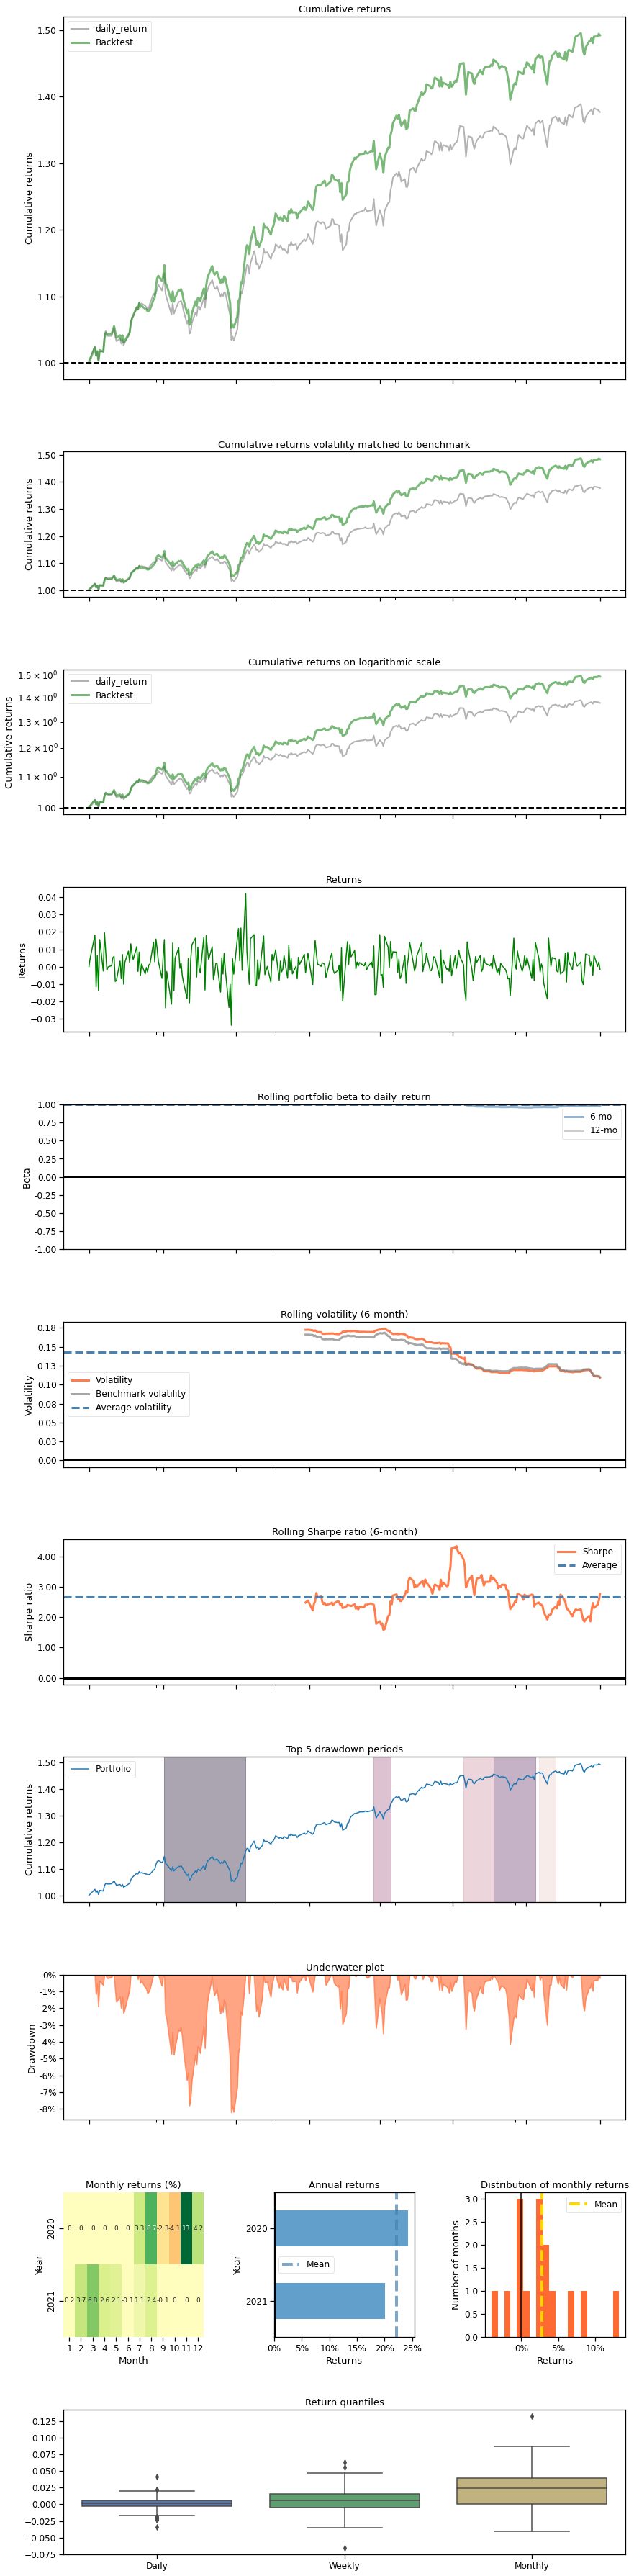

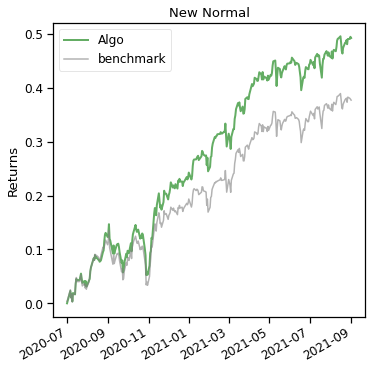

In [25]:
%matplotlib inline
TD3_Agent_OHCLVW_SftMx.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

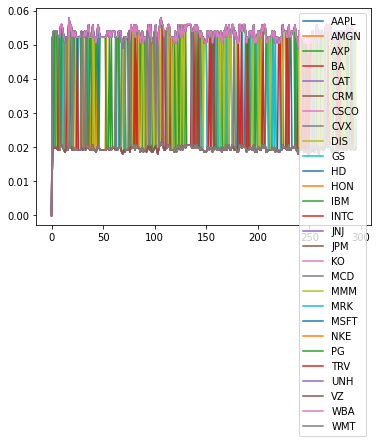

In [26]:
%matplotlib inline
TD3_Agent_OHCLVW_SftMx.pf_weights_hist.plot()

<AxesSubplot:>

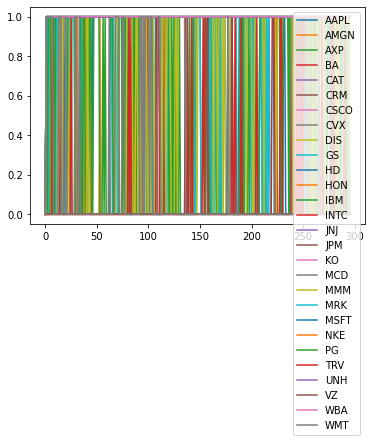

In [27]:
TD3_Agent_OHCLVW_SftMx.agt_action_hist.plot()

In [75]:
df_pf_value_hist_det

date   daily_value
0     2008-12-31  1.000000e+06
1     2009-01-02  1.030999e+06
2     2009-01-05  1.025469e+06
3     2009-01-06  1.027855e+06
4     2009-01-07  1.000027e+06
...          ...           ...
2889  2020-06-24  5.799320e+06
2890  2020-06-25  5.868907e+06
2891  2020-06-26  5.709391e+06
2892  2020-06-29  5.817126e+06
2893  2020-06-30  5.879899e+06

[2894 rows x 2 columns]

In [74]:
df_pf_return_hist_det['daily_return'].to_numpy()

array([ 0.        ,  0.03099932, -0.00536389, ..., -0.02717983,
        0.0188697 ,  0.01079115])

In [76]:
df_pf_value_hist_det['daily_value'].iloc[-1]

5879899.090096481

In [77]:
type(df_pf_value_hist_det['daily_value'].iloc[-1])

numpy.float64

## Seed testing

Will loop over a set of seeds. For training Sharpe ratios over 0.93, we'll record the training Sharpe ratio, the testing Sharpe, and the final portfolio value.

In [6]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "softmax"

In [7]:
train_env_sftmx = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [8]:
test_env_sftmx = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [9]:
TD3_PARAMS = {"batch_size": 256, 
              "buffer_size": 10000, 
              "learning_rate": 0.01,
              "gamma":0,
              #"action_noise":"ornstein_uhlenbeck",
             }

In [10]:
# Instantiate agent
TD3_Agent_OHCLVW_SftMx = PFOptAgent_XP(train_env = train_env_sftmx)

**Main loop:**

In [11]:
#Initializations
seed_list = []
train_Sharpe_list = []
train_final_val_list = []
test_Sharpe_list = []
test_cumul_return_list = []


In [ ]:
#### for seed in range(2):
for seed in range(251):
    print("################")
    print(f"### SEED = {seed} ###")
    print("################")
    # Delete previous agent and make new
    del TD3_Agent_OHCLVW_SftMx
    TD3_Agent_OHCLVW_SftMx = PFOptAgent_XP(train_env = train_env_sftmx)
    
    # Create TD3 agent with current seed and params above
    TD3_Agent_OHCLVW_SftMx.set_model(model_name = "td3",
                                seed = seed,
                                model_kwargs=TD3_PARAMS)
    print("==================================================================")
    
    # Train model for 1 round
    print("Training model")
    TD3_Agent_OHCLVW_SftMx.train_model(tb_log_name='td3',
                                  n_train_rounds=1)
    
    # Get approximate training Sharpe ratio
    df_pf_value_hist_tr, df_pf_return_hist_tr, \
    df_pf_weights_hist_tr, df_agt_action_hist_tr\
     = TD3_Agent_OHCLVW_SftMx.run_backtest(test_env = train_env_sftmx,)
    
    train_pf_return_hist = df_pf_return_hist_tr['daily_return'].to_numpy()
    train_Sharpe = ((252**0.5)*train_pf_return_hist.mean())/(train_pf_return_hist.std())
    train_final_val = df_pf_value_hist_tr['daily_value'].iloc[-1]
    
    # Run backtest on test data
    print("Running backtest on test data")
    df_pf_value_hist_ts, df_pf_return_hist_ts, \
    df_pf_weights_hist_ts, df_agt_action_hist_ts\
     = TD3_Agent_OHCLVW_SftMx.run_backtest(test_env = test_env_sftmx,)
    
    # Get test Sharpe ratio and cumulative return
    test_pf_return_hist = df_pf_return_hist_ts['daily_return'].to_numpy()
    test_Sharpe = ((252**0.5)*test_pf_return_hist.mean())/(test_pf_return_hist.std())
    #test_final_pf_value = df_pf_value_hist_ts['daily_value'].iloc[-1]
    test_cumul_return = (df_pf_value_hist_ts['daily_value'].iloc[-1]-pf_value_ini)/pf_value_ini
    print("==================================================================")
    
    # Record seed according to results:
    if (train_Sharpe>=0.94) or (test_Sharpe>=2.15) or (test_cumul_return>=0.43):
        seed_list.append(seed)
        train_Sharpe_list.append(train_Sharpe)
        train_final_val_list.append(train_final_val)
        test_Sharpe_list.append(test_Sharpe)
        test_cumul_return_list.append(test_cumul_return)
        
# Make result dataframe and save to csv
df_results = pd.DataFrame({"Seed":seed_list,
                           "Training final val.":train_final_val_list,
                           "Training Sharpe": train_Sharpe_list,
                           "Test cumul. ret.":test_cumul_return_list,
                           "Test Sharpe": test_Sharpe_list,
                          })
df_results.to_csv("TD3_OHCLVW_SftMx_Seeds_0-250_221105.csv")

In [91]:
df_results

Seed  Training final val.  Training Sharpe  Test cumul. ret.  Test Sharpe
0     0         6.014091e+06         0.963183          0.367341     1.964711
1     1         6.029483e+06         0.943760          0.434636     2.262757
2     4         6.593453e+06         0.970792          0.455465     2.311952

In [15]:
df_results['Test cumul. ret.'].argmax()

100

In [16]:
df_results['Test cumul. ret.'].max()

0.4923772375533646

In [17]:
df_results['Test Sharpe'].max()

2.4698110147193413

In [18]:
df_results['Test Sharpe'].argmax()

100

In [19]:
df_results['Seed'].iloc[df_results['Test Sharpe'].argmax()]

119

## TD3 best seed - Normalized ReLU 

In [8]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "relu"

In [9]:
train_env_relu = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [10]:
test_env_relu = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [9]:
train_env_sftmx.N_periods

2894

In [20]:
del TD3_Agent_OHCLVW_ReLU

In [11]:
# Instantiate agent
TD3_Agent_OHCLVW_ReLU = PFOptAgent_XP(train_env = train_env_relu)

In [12]:
TD3_PARAMS = {"batch_size": 256, 
              "buffer_size": 10000, 
              "learning_rate": 0.01,
              "gamma":0,
              "action_noise":"ornstein_uhlenbeck",}

TD3_Agent_OHCLVW_ReLU.set_model(model_name = "td3",
                                seed = 119,
                                model_kwargs=TD3_PARAMS)

{'batch_size': 256, 'buffer_size': 10000, 'learning_rate': 0.01, 'gamma': 0, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3 with given parameters has been successfully created.


True

In [13]:
TD3_Agent_OHCLVW_ReLU.train_model(tb_log_name='td3',
                                  n_train_rounds=12)

Initial portfolio value: 1000000
End portfolio value: 6985480.524985928
Yearly Sharpe ratio at last period: 0.9628810723942349
Initial portfolio value: 1000000
End portfolio value: 7390404.032460675
Yearly Sharpe ratio at last period: 0.9679610326132326
Initial portfolio value: 1000000
End portfolio value: 7545503.697007343
Yearly Sharpe ratio at last period: 0.9751453657967111
Initial portfolio value: 1000000
End portfolio value: 7483055.879124584
Yearly Sharpe ratio at last period: 0.971444147370231
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 2.89e+03    |
|    ep_rew_mean     | 2.24        |
| time/              |             |
|    episodes        | 4           |
|    fps             | 93          |
|    time_elapsed    | 124         |
|    total_timesteps | 11576       |
| train/             |             |
|    actor_loss      | -12.7       |
|    critic_loss     | 1.4e+07     |
|    learning_rate   | 0.01        |
|    n_updat

In [14]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = TD3_Agent_OHCLVW_ReLU.run_backtest(test_env = test_env_relu,)

Initial portfolio value: 1000000
End portfolio value: 1601091.9968540422
Yearly Sharpe ratio at last period: 2.7480577501470793
Finished running backtest. Storing results...


True

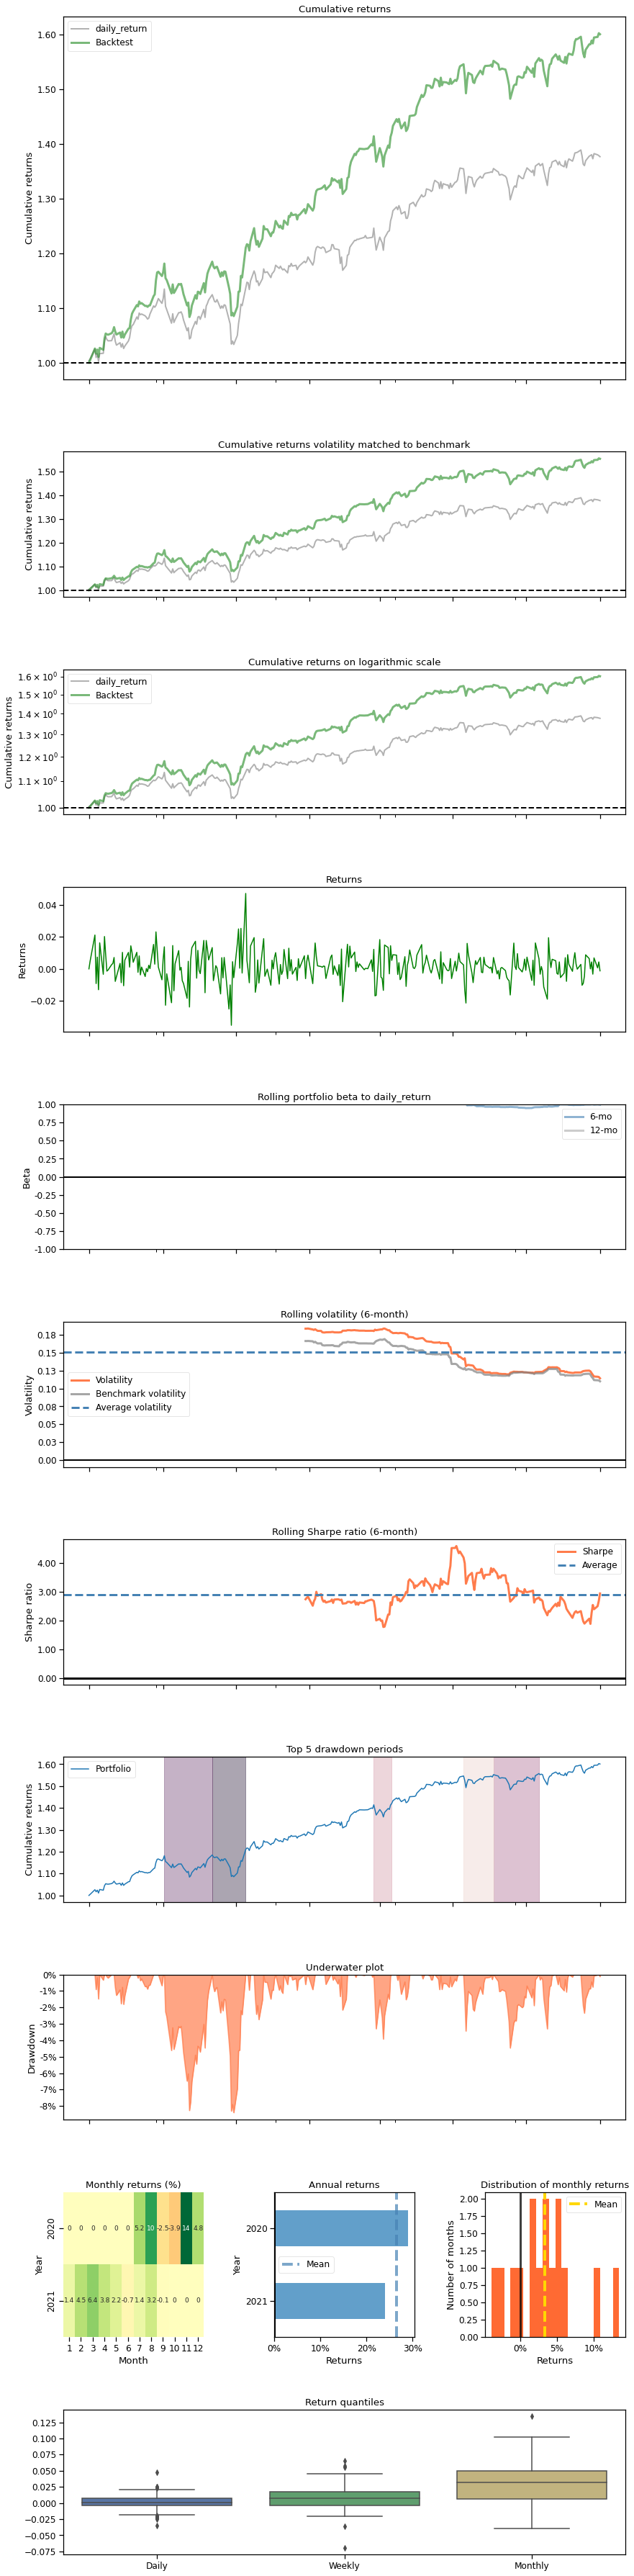

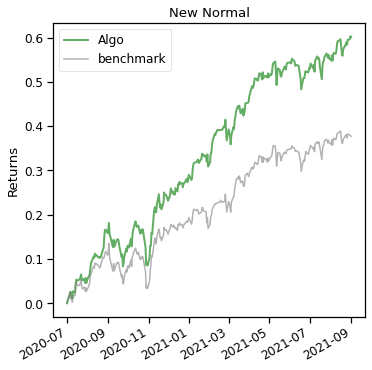

In [15]:
%matplotlib inline
TD3_Agent_OHCLVW_ReLU.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

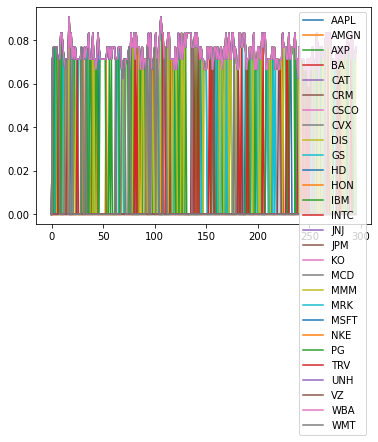

In [16]:
TD3_Agent_OHCLVW_ReLU.pf_weights_hist.plot()

<AxesSubplot:>

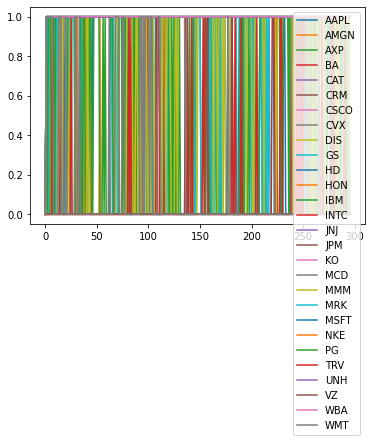

In [17]:
TD3_Agent_OHCLVW_ReLU.agt_action_hist.plot()

## TD3_OHLCVW New params (TD3_PARAMS), Seed = 119

In [11]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "relu"

In [12]:
train_env_OHLCVW = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [13]:
test_env_OHLCVW = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [14]:
train_env_OHLCVW.N_periods

2894

In [18]:
del TD3_OHCLVW

In [19]:
# Instantiate agent
TD3_OHCLVW = PFOptAgent_XP(train_env = train_env_OHLCVW)

In [20]:
TD3_PARAMS = {"batch_size": 256, 
              "buffer_size": 10000,
              "learning_rate": 0.01,
              "gamma":0,
              "train_freq": (5, "step"),
              "policy_delay":1,
              "learning_starts":5,
              "action_noise":"ornstein_uhlenbeck",}

TD3_OHCLVW.set_model(model_name = "td3",
                     seed = 119,
                     model_kwargs=TD3_PARAMS)

{'batch_size': 256, 'buffer_size': 10000, 'learning_rate': 0.01, 'gamma': 0, 'train_freq': (5, 'step'), 'policy_delay': 1, 'learning_starts': 5, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3 with given parameters has been successfully created.


True

In [21]:
TD3_OHCLVW.train_model(tb_log_name='td3',
                       progress_bar = True,
                       n_train_rounds=4)

Output()

=================================

Initial portfolio value: 1000000

End portfolio value: 7223292.466625194

Yearly Sharpe ratio at last period: 0.9573525891332446

=================================

=================================

End portfolio value: 7438363.360583425

Yearly Sharpe ratio at last period: 0.9678809779107805

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 7436487.8930344125

Yearly Sharpe ratio at last period: 0.9673152091361239

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 7478641.232163871

Yearly Sharpe ratio at last period: 0.9685950192039643

=================================

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.89e+03 |
|    ep_rew_mean     | 2.25     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 61       |
|    time_elapsed    | 189      |
|    total_timesteps | 11576    |
| train/             |          |
|    actor_loss      | 68.2     |
|    critic_loss     | 5.65e+06 |
|    learning_rate   | 0.01     |
|    n_updates       | 11570    |
---------------------------------


In [22]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = TD3_OHCLVW.run_backtest(test_env = test_env_OHLCVW,)

Initial portfolio value: 1000000
End portfolio value: 1601091.9968540422
Yearly Sharpe ratio at last period: 2.7480577501470793
Finished running backtest. Storing results...


In [23]:
%matplotlib inline

True

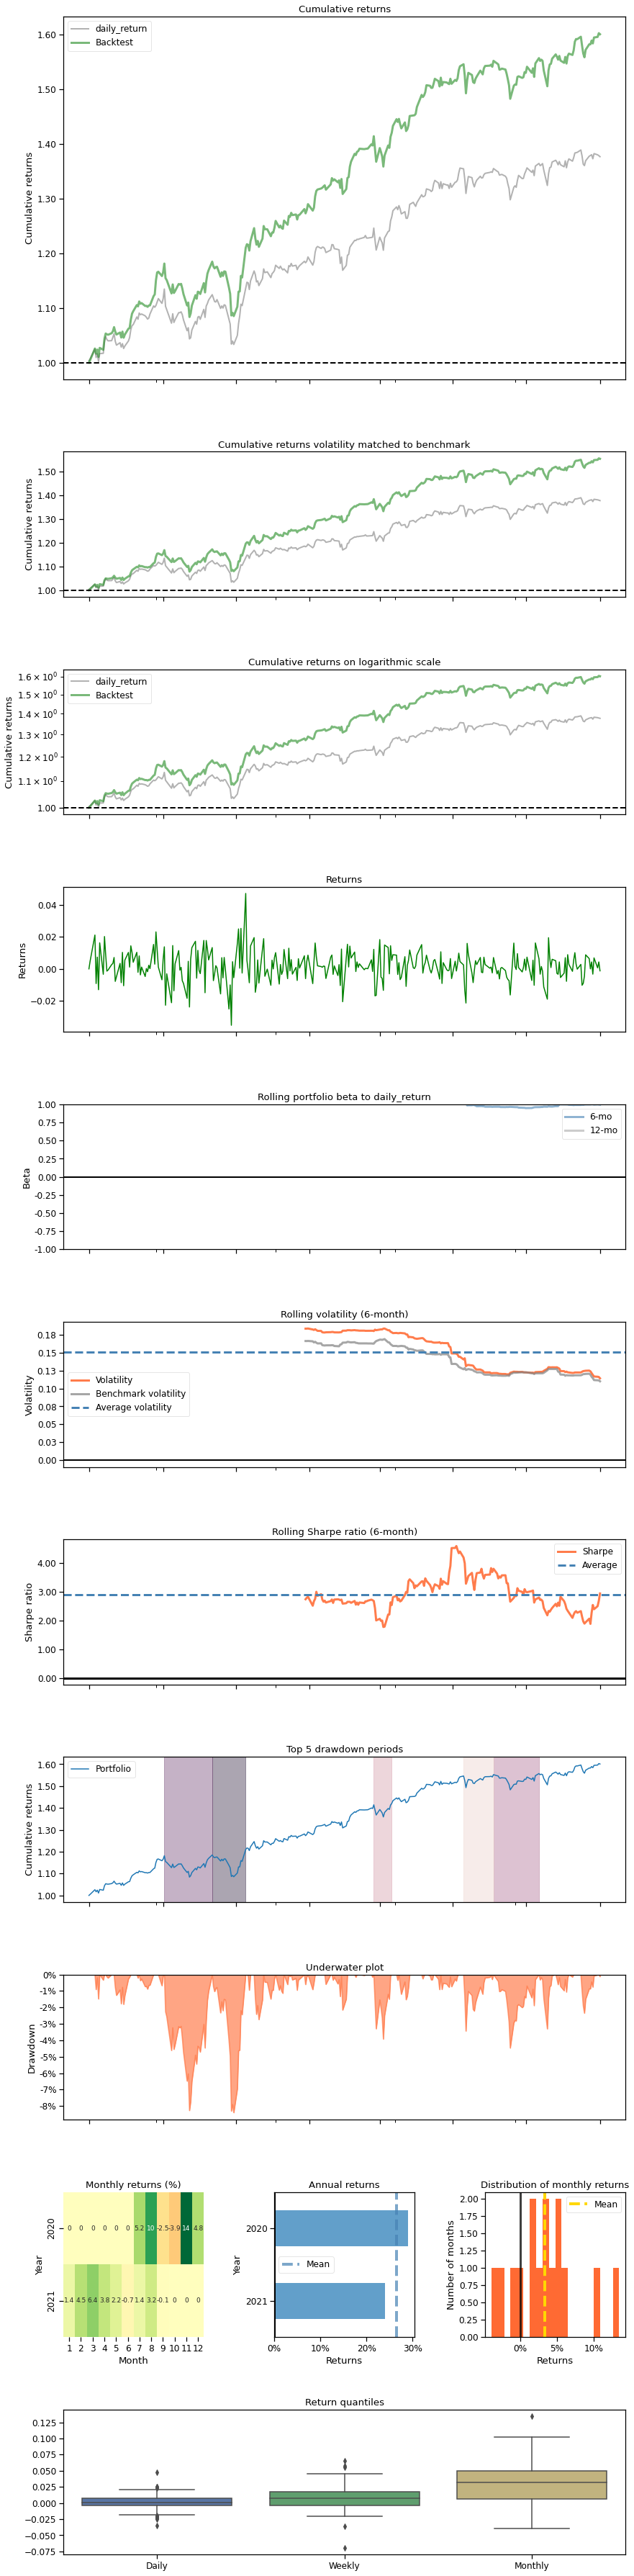

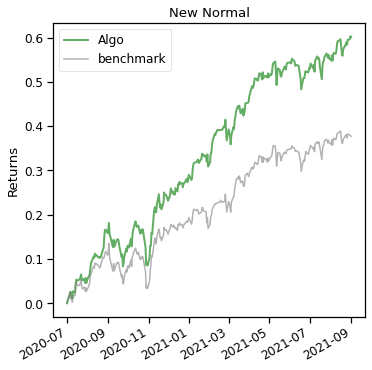

In [26]:
TD3_OHCLVW.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

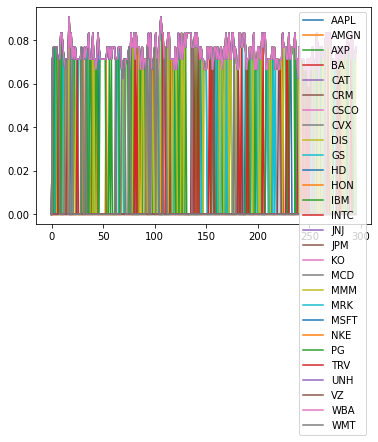

In [27]:
TD3_OHCLVW.pf_weights_hist.plot()

<AxesSubplot:>

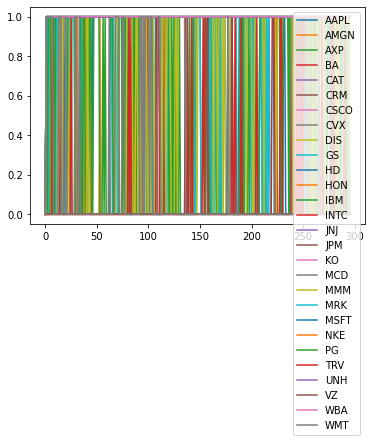

In [28]:
TD3_OHCLVW.agt_action_hist.plot()

## TD3_OHLCVW New params (TD3_PARAMS), Seed = 37

In [11]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "relu"

In [12]:
train_env_OHLCVW = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [13]:
test_env_OHLCVW = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [14]:
train_env_OHLCVW.N_periods

2894

In [29]:
del TD3_OHCLVW

In [30]:
# Instantiate agent
TD3_OHCLVW = PFOptAgent_XP(train_env = train_env_OHLCVW)

In [31]:
TD3_PARAMS = {"batch_size": 256, 
              "buffer_size": 10000,
              "learning_rate": 0.01,
              "gamma":0,
              "train_freq": (5, "step"),
              "policy_delay":1,
              "learning_starts":5,
              "action_noise":"ornstein_uhlenbeck",}

TD3_OHCLVW.set_model(model_name = "td3",
                     seed = 37,
                     model_kwargs=TD3_PARAMS)

{'batch_size': 256, 'buffer_size': 10000, 'learning_rate': 0.01, 'gamma': 0, 'train_freq': (5, 'step'), 'policy_delay': 1, 'learning_starts': 5, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3 with given parameters has been successfully created.


True

In [32]:
TD3_OHCLVW.train_model(tb_log_name='td3',
                       progress_bar = True,
                       n_train_rounds=4)

Output()

=================================

Initial portfolio value: 1000000

End portfolio value: 5861140.099466748

Yearly Sharpe ratio at last period: 0.9757322394967776

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 5682298.681683709

Yearly Sharpe ratio at last period: 0.9553631769728045

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 5805838.51289399

Yearly Sharpe ratio at last period: 0.9685428257526246

=================================

=================================

Initial portfolio value: 1000000

End portfolio value: 5833084.955808375

Yearly Sharpe ratio at last period: 0.9700416362232244

=================================

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.89e+03 |
|    ep_rew_mean     | 1.94     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 61       |
|    time_elapsed    | 188      |
|    total_timesteps | 11576    |
| train/             |          |
|    actor_loss      | 1.59     |
|    critic_loss     | 6.3e+05  |
|    learning_rate   | 0.01     |
|    n_updates       | 11570    |
---------------------------------


In [33]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = TD3_OHCLVW.run_backtest(test_env = test_env_OHLCVW,)

Initial portfolio value: 1000000
End portfolio value: 1299542.4658634306
Yearly Sharpe ratio at last period: 1.68586223903368
Finished running backtest. Storing results...


In [34]:
%matplotlib inline

True

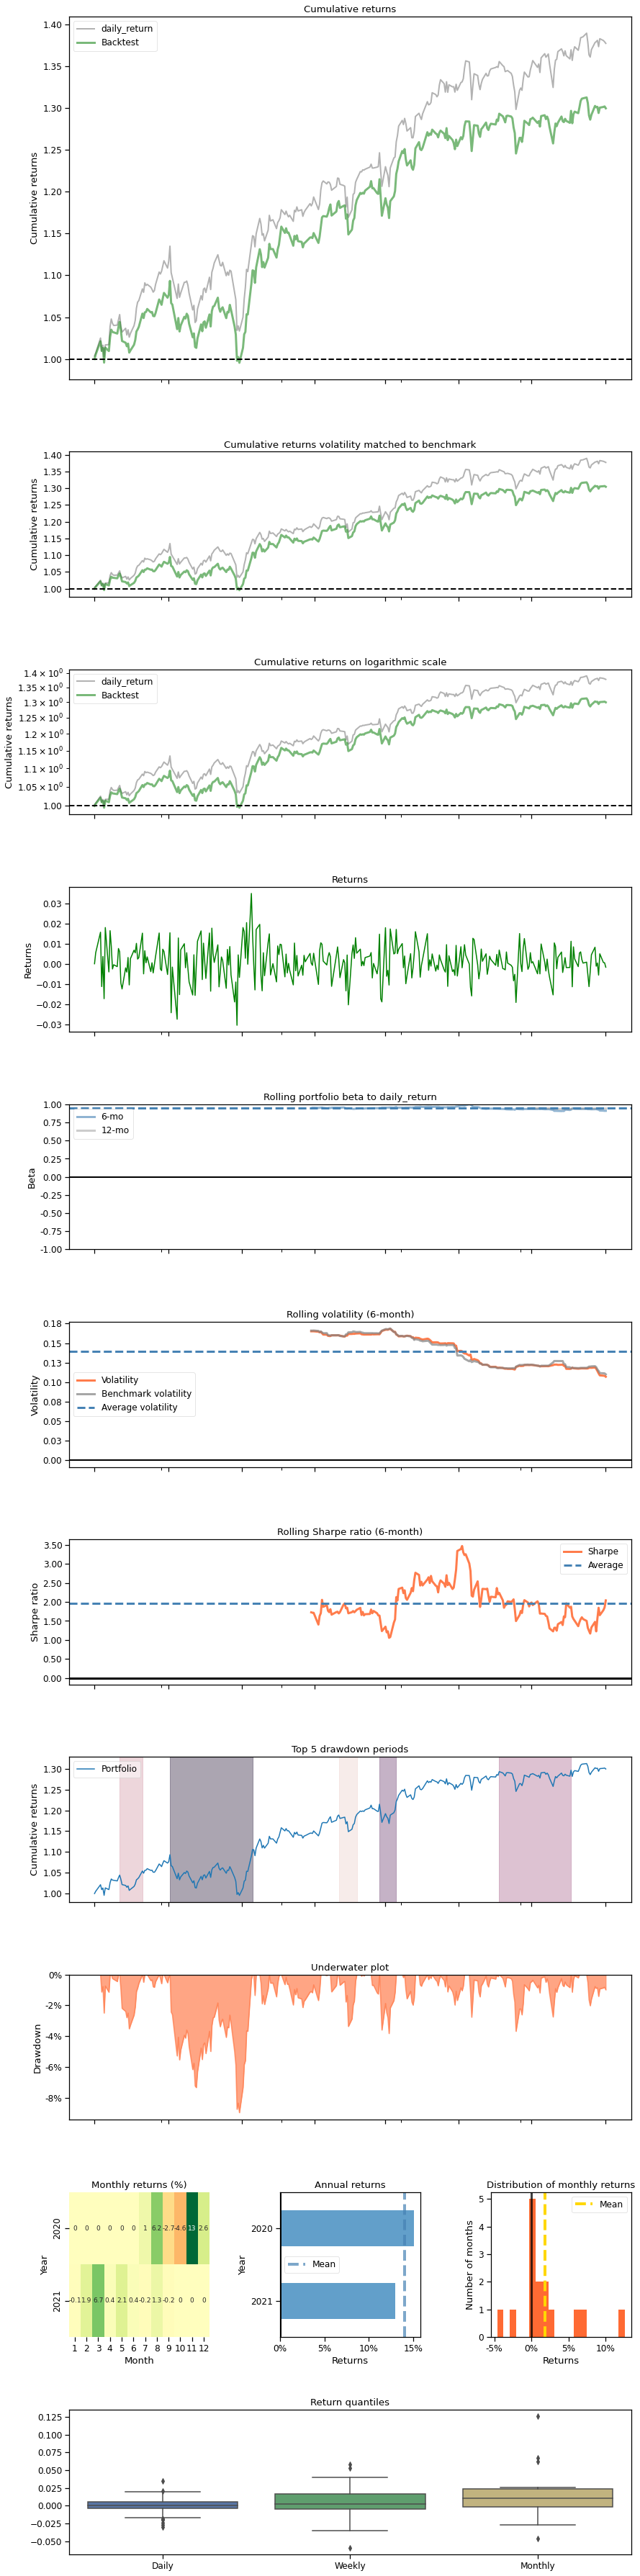

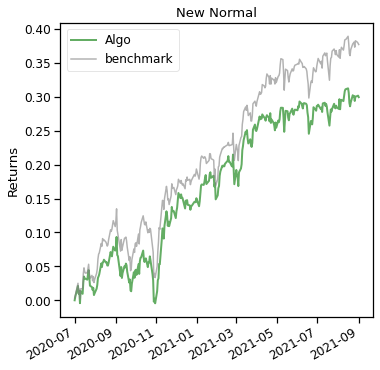

In [37]:
TD3_OHCLVW.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

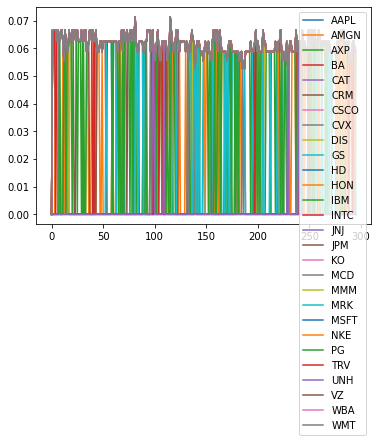

In [35]:
TD3_OHCLVW.pf_weights_hist.plot()

<AxesSubplot:>

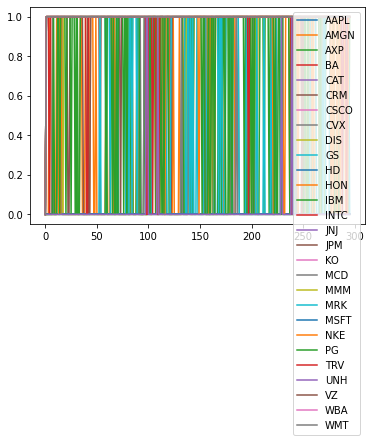

In [36]:
TD3_OHCLVW.agt_action_hist.plot()

******

# Seed Testing (22/11/26)

More seed testing with updated package.


In [1]:
# Kill warnings
from warnings import filterwarnings
filterwarnings("ignore")

### IMPORTS ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, date
#import holidays # NEW, 22/11/21
import pandas_market_calendars as pd_mkt_cals


import MyAlpaca

from drl_pfopt import (PFOpt_DRL_Agent, PortfolioOptEnv, 
                       data_split, FeatureEngineer, 
                       AlpacaDownloader, YahooDownloader)
from drl_pfopt.common.benchmarks import get_eq_wts_benchmark, get_benchmark_prices_and_returns
from drl_pfopt.common.data.data_utils import get_market_calendar_day_list, get_timeframe_info